# Linear Regression Email Spam Classifier



### 1. Fetch Spam Assassin Data

HAM and SPAM represent non-spam and spam emails respectively.

In [1]:
import os 
import shutil
from modules.download import DataDownloader

In [2]:
# Set up variables for downloading the data

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_FILE = "20030228_easy_ham.tar.bz2"
SPAM_FILE = "20030228_spam.tar.bz2"
HAM_URL = DOWNLOAD_ROOT + HAM_FILE
SPAM_URL = DOWNLOAD_ROOT + SPAM_FILE
SPAM_PATH = os.path.join("datasets", "spam") # datasets/spam
HAM_PATH = os.path.join("datasets", "ham") # datasets/ham

In [3]:
# Create a DataDownloader object and download the files

data = DataDownloader(DOWNLOAD_ROOT, [HAM_FILE, SPAM_FILE])
data.download()

Filetype:  bz2
Done!
Filetype:  bz2
Done!


In [4]:
# Modify file directory for convenience

sources = ["datasets/20030228_easy_ham.tar.bz2/easy_ham", "datasets/20030228_spam.tar.bz2/spam"]
for source in sources: 
    shutil.move(source, "datasets", copy_function=shutil.copytree)
    os.rmdir(os.path.dirname(source))
    # print(os.path.dirname(source))

In [5]:
os.rename("datasets/easy_ham", "datasets/ham")

----

### 2. Parsing Data

In [6]:
import email
import pandas as pd
import numpy as np

In [7]:
# Assemble pd database from parsing

content = []
# Loop through ham and spam
for ham_or_spam in os.listdir("datasets/"):
    for file in os.listdir("datasets/" + ham_or_spam):
        path_to_email = os.path.join("datasets", ham_or_spam, file)
        with open(path_to_email, "rb") as email_file:
            # Parse the email message using the email package
            message = email.message_from_binary_file(email_file)

            # Get the subject of the email
            subject = message["Subject"]

            # Get the sender of the email
            sender = message["From"]

            # Get the recipient(s) of the email
            recipients = message["To"]

            # Get the body of the email
            if message.is_multipart():
                for part in message.walk():
                    content_type = part.get_content_type()
                    content_disposition = str(part.get("Content-Disposition"))
                    if content_type == "text/plain" and "attachment" not in content_disposition:
                        body = part.get_payload()
                        break
            else:
                body = message.get_payload()
            
            content.append([subject, sender, body, recipients, 1 if ham_or_spam == "spam" else 0])


In [8]:
data_representation = np.array(content)
df = pd.DataFrame(data_representation, columns = ["Subject", "Sender", "Body", "Recipient", "Spam"])
df.head()

,Subject,Sender,Body,Recipient,Spam
0,Re: New Sequences Window,Robert Elz <kre@munnari.OZ.AU>,"Date: Wed, 21 Aug 2002 10:54:46 -05...",Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,0
1,[zzzzteana] RE: Alexander,Steve Burt <Steve_Burt@cursor-system.com>,"Martin A posted:\nTassos Papadopoulos, the Gre...","""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...",0
2,[zzzzteana] Moscow bomber,"""Tim Chapman"" <timc@2ubh.com>",Man Threatens Explosion In Moscow \n\nThursday...,zzzzteana <zzzzteana@yahoogroups.com>,0
3,[IRR] Klez: The Virus That Won't Die,Monty Solomon <monty@roscom.com>,Klez: The Virus That Won't Die\n \nAlready the...,undisclosed-recipient: ;,0
4,Re: [zzzzteana] Nothing like mama used to make,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,"> in adding cream to spaghetti carbonara, whi...",zzzzteana@yahoogroups.com,0


----

### 3. Data Exploration

In [9]:
df[df["Spam"]==1].head()

,Subject,Sender,Body,Recipient,Spam
2501,Life Insurance - Why Pay More?,12a1mailbot1@web.de,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",<dcek1a1@netsgo.com>,1
2502,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,"""Slim Down"" <taylor@s3.serveimage.com>",1) Fight The Risk of Cancer!\nhttp://www.adcli...,<ilug@linux.ie>,1
2503,Guaranteed to lose 10-12 lbs in 30 days ...,"""Slim Down"" <sabrina@mx3.1premio.com>",1) Fight The Risk of Cancer!\nhttp://www.adcli...,<zzzz@spamassassin.taint.org>,1
2504,Re: Fw: User Name & Password to Membership To ...,Account Services <wsup@playful.com>,##############################################...,zzzz@spamassassin.taint.org,1
2505,[ILUG-Social] re: Guaranteed to lose 10-12 lbs...,"""Slim n Trim"" <yenene@mx2.1premio.com>",I thought you might like these:\n1) Slim Down ...,<social@linux.ie>,1


In [10]:
print(df.iloc[0]["Body"].strip())

Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>


  | I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ...

Note, if I run the pick command by hand ...

delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit

That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ...

delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55:56 

In [11]:
df["Body"].head()

0        Date:        Wed, 21 Aug 2002 10:54:46 -05...
1    Martin A posted:\nTassos Papadopoulos, the Gre...
2    Man Threatens Explosion In Moscow \n\nThursday...
3    Klez: The Virus That Won't Die\n \nAlready the...
4    >  in adding cream to spaghetti carbonara, whi...
Name: Body, dtype: object

---

### 4. Preprocessing

In [12]:
from modules.processing import Process
import nltk

In [13]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amira\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\amira\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [14]:
processed_text = []
for index, row in df.iterrows():
    # tx = Process.clean_everything(df.loc[index]["Body"])
    # tx = Process.stop_word_removal(tx)
    # tx = Process.lem_words(tx)
    # tx = Process.lower_case(tx)
    tx = Process.all(df.loc[index]["Body"])
    processed_text.append(tx)

df["Processed"] = processed_text
df.head()

,Subject,Sender,Body,Recipient,Spam,Processed
0,Re: New Sequences Window,Robert Elz <kre@munnari.OZ.AU>,"Date: Wed, 21 Aug 2002 10:54:46 -05...",Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,0,date wed # aug # # # # # chris garrigues email...
1,[zzzzteana] RE: Alexander,Steve Burt <Steve_Burt@cursor-system.com>,"Martin A posted:\nTassos Papadopoulos, the Gre...","""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...",0,martin posted tassos papadopoulos greek sculpt...
2,[zzzzteana] Moscow bomber,"""Tim Chapman"" <timc@2ubh.com>",Man Threatens Explosion In Moscow \n\nThursday...,zzzzteana <zzzzteana@yahoogroups.com>,0,man threatens explosion moscow thursday august...
3,[IRR] Klez: The Virus That Won't Die,Monty Solomon <monty@roscom.com>,Klez: The Virus That Won't Die\n \nAlready the...,undisclosed-recipient: ;,0,klez virus wont die already prolific virus eve...
4,Re: [zzzzteana] Nothing like mama used to make,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,"> in adding cream to spaghetti carbonara, whi...",zzzzteana@yahoogroups.com,0,adding cream spaghetti carbonara effect pasta ...


#### Data Viz

Let us compare the word clouds for the emails before the processing and after the processing:

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

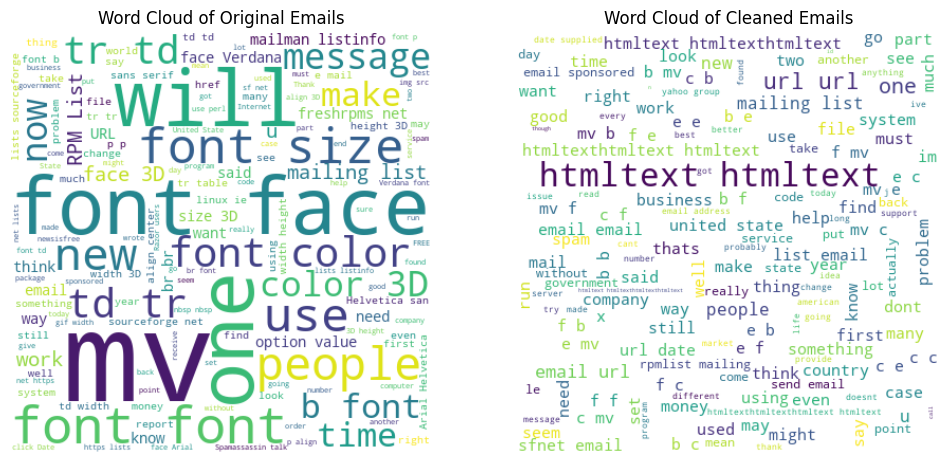

In [16]:
# Generate word cloud for original text
original_text = ' '.join(df['Body'])
wordcloud_original = WordCloud(width=400, height=400, max_words=150, background_color='white').generate(original_text)

# Generate word cloud for cleaned text
cleaned_text = ' '.join(df['Processed'])
wordcloud_cleaned = WordCloud(width=400, height=400, max_words=150, background_color='white').generate(cleaned_text)

# Create subplots to display word clouds side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(wordcloud_original, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud of Original Emails')
axes[1].imshow(wordcloud_cleaned, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud of Cleaned Emails')

plt.show()


It would also be pretty interesting to compare the word clouds for the spam emails and the ham emails following the processing:

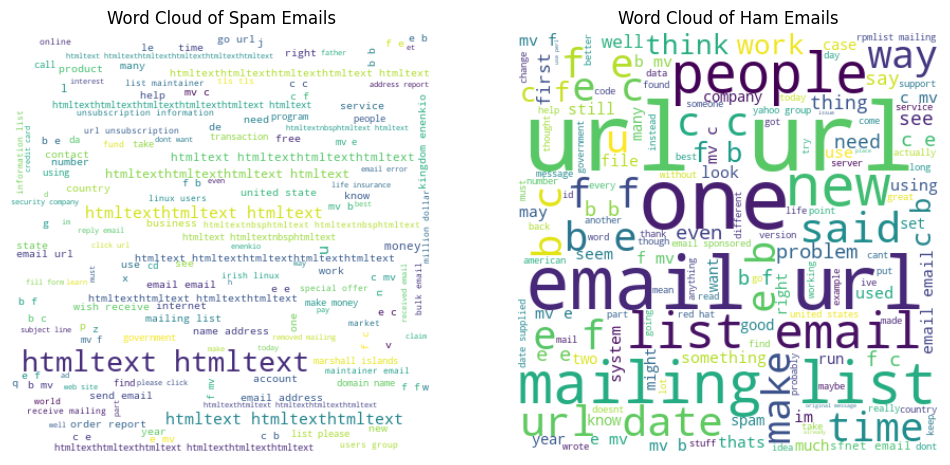

In [17]:
# Generate word cloud for spam text
spam_text = ' '.join(df[df['Spam'] == 1]['Processed'])
wordcloud_spam = WordCloud(width=400, height=400, max_words=150, background_color='white').generate(spam_text)

# Generate word cloud for non-spam text
ham_text = ' '.join(df[df['Spam'] == 0]['Processed'])
wordcloud_ham = WordCloud(width=400, height=400, max_words=150, background_color='white').generate(ham_text)

# Create subplots to display word clouds side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(wordcloud_spam, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud of Spam Emails')
axes[1].imshow(wordcloud_ham, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud of Ham Emails')

plt.show()

---

### 5. Training & Evaluating Models

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [19]:
# convert pandas series datatype from object to int
df["Spam"] = df["Spam"].astype(int)

#### Logistic Regression

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(df["Processed"], df["Spam"], test_size=0.2, random_state=42)

In [21]:
vectorizer= TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [22]:
model = LogisticRegression()
model.fit(X_train_vectorized, Y_train)

LogisticRegression()

In [23]:
Y_pred = model.predict(X_test_vectorized)
matrix = confusion_matrix(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)

Let's see how the model did now:

In [24]:
import textwrap 
import seaborn as sns

In [25]:
print("\t\t" +  textwrap.dedent(report).strip())

		precision    recall  f1-score   support

           0       0.95      1.00      0.97       497
           1       1.00      0.75      0.86       104

    accuracy                           0.96       601
   macro avg       0.98      0.88      0.92       601
weighted avg       0.96      0.96      0.95       601


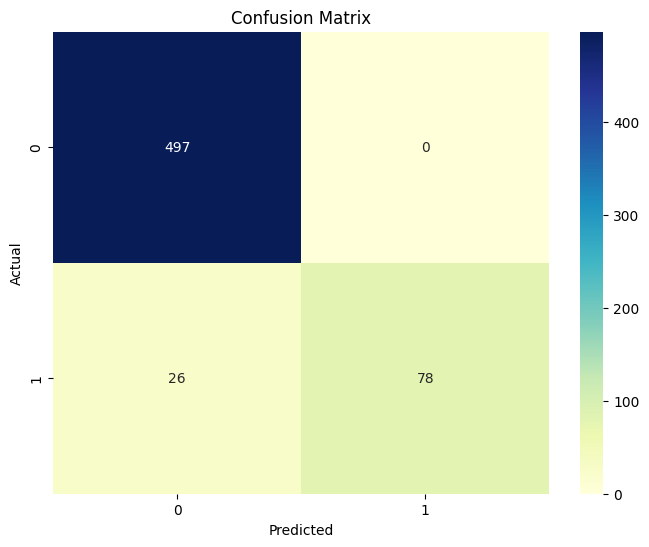

In [26]:
plt.figure(figsize = (8,6))
sns.heatmap(matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 6. Testing the Models

In [27]:
"""
Classify a new email from user input
"""

sample_email = input("Provide some email to classify: ")

string = Process.all(sample_email)
X_new = vectorizer.transform([string])
Y_pred = model.predict(X_new)

print("Classification:\n \"" +  sample_email[:20] + "\"... is: " + "spam" if Y_pred else "ham")

Classification:
 "Please click this li"... is: spam


### 7. Exporting

In [28]:
from joblib import dump

In [29]:
dump(model, 'models/logistic_regression.joblib')

['models/logistic_regression.joblib']